In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit.primitives import Estimator
import matplotlib.pyplot as plt

In [2]:
# Define parameters
J = 1.0  # coupling constant XX and YY
U = 1.0  # coupling constant ZZ
num_qubits = 6  # number of qubits
hj_list = [0]*num_qubits
t = 2.5  # total time
n = 250  # number of Trotter steps
dt = t / n  # time step

In [3]:
def get_hjlist(num_qubits,h):
    return np.random.uniform(-h,h,num_qubits)

In [4]:
def get_Hamiltonian(num_qubits, J, U, h_list):
    XX_tuples = [("XX", [i, i + 1], -J) for i in range(0, num_qubits - 1)]
    YY_tuples = [("YY", [i, i + 1], -J) for i in range(0, num_qubits - 1)]
    ZZ_tuples = [("ZZ", [i, i + 1], U) for i in range(0, num_qubits - 1)]
    Z_tuples = [("XX", [i], h_list[i]) for i in range(num_qubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples,*YY_tuples,*ZZ_tuples, *Z_tuples], num_qubits=num_qubits)
    return hamiltonian.simplify()

In [21]:
def get_wall_state(num_qubits):
    wallstate = int(num_qubits/2)
    qc = Statevector.from_label("1"*wallstate+"0"*wallstate)
    return qc

def get_neel_state(num_qubits):
    neelstate = '01'*(num_qubits//2+1)
    qc = Statevector.from_label(neelstate[:num_qubits])
    return qc

In [6]:
def create_nhalf(num_qubits):
    pauli_list = []
    coeffs = []

    for i in range(num_qubits//2):
        # Create Z_i term
        z_term = ['I'] * num_qubits
        z_term[i] = 'Z'
        z_str = ''.join(z_term)
        
        # (Z_i + 1)/2 = 0.5 * Z_i + 0.5 * I
        pauli_list.append(z_str)
        coeffs.append(0.5)
        
        pauli_list.append('I' * num_qubits)
        coeffs.append(0.5)
    
    # Create SparsePauliOp
    sparse_pauli_op = SparsePauliOp.from_list(zip(pauli_list, coeffs))
    return sparse_pauli_op

In [7]:
def compute_local_magnetism(statevector):
    num_qubits = statevector.num_qubits
    local_magnetism = []

    for i in range(num_qubits):
        # Define the Pauli-Z operator for qubit i
        Z_i = Pauli('I' * i + 'Z' + 'I' * (num_qubits - i - 1))
        
        # Calculate the expectation value of Z_i
        expectation_value = np.real(statevector.expectation_value(Z_i))
        local_magnetism.append(expectation_value)

    return local_magnetism

def compute_N_half(statevector):
    num_qubits = statevector.num_qubits
    N_half = 0

    for i in range(num_qubits):
        # Define the operator (Z_i + 1)/2 for qubit i
        Z_i = Pauli('I' * i + 'Z' + 'I' * (num_qubits - i - 1))
        operator = (Z_i + Operator.from_label('I' * num_qubits)) / 2
        
        # Calculate the expectation value of (Z_i + 1)/2
        expectation_value = np.real(statevector.expectation_value(operator))
        N_half += expectation_value

    return N_half

In [8]:
def get_s(i,N):
    if i<N/2:
        return -1
    return 1

N = num_qubits
magnetization_op_list = [SparsePauliOp('I'*i+'Z'+'I'*(num_qubits-i-1), 1.0) for i in range(0, num_qubits)]
#nhalf_op = SparsePauliOp.from_sparse_list([("Z", [i], 0.5), ("I", [i], 0.5) for i in range(0, num_qubits)], num_qubits=num_qubits)
nhalf_op = create_nhalf(num_qubits = num_qubits)
pauli_strings = []
coefficients = []

# Construct Pauli strings and coefficients
for i in range(num_qubits):
    for j in range(i, num_qubits):
        # Create a Z_i Z_j string
        z_string = ['I'] * num_qubits
        z_string[i] = 'Z'
        z_string[j] = 'Z'
        pauli_strings.append(''.join(z_string))
        coefficients.append(get_s(i,N) * get_s(j,N))

# Convert to numpy array for coefficients
coefficients = np.array(coefficients, dtype=complex)

# Create the SparsePauliOp
paulis = [Pauli(label) for label in pauli_strings]

fq_op1 = SparsePauliOp(paulis, coefficients)
fq_op2 = SparsePauliOp.from_sparse_list([("Z", [i], get_s(i,num_qubits)) for i in range(0, num_qubits)], num_qubits=num_qubits)

In [9]:
H = get_Hamiltonian(num_qubits,J,U,hj_list)
qc = get_wall_state(num_qubits)
problem = TimeEvolutionProblem(H, initial_state=qc, time=t, aux_operators=magnetization_op_list)
trotter = TrotterQRTE(num_timesteps=n, estimator=Estimator())
result = trotter.evolve(problem)
observables = np.array(np.array(result.observables)[:, :, 0])

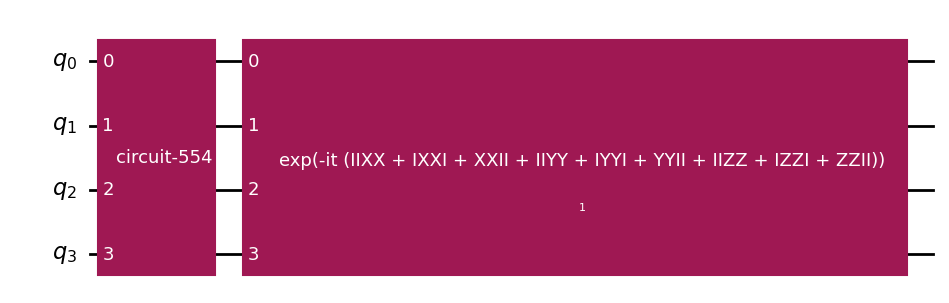

In [14]:
result.evolved_state.draw("mpl")

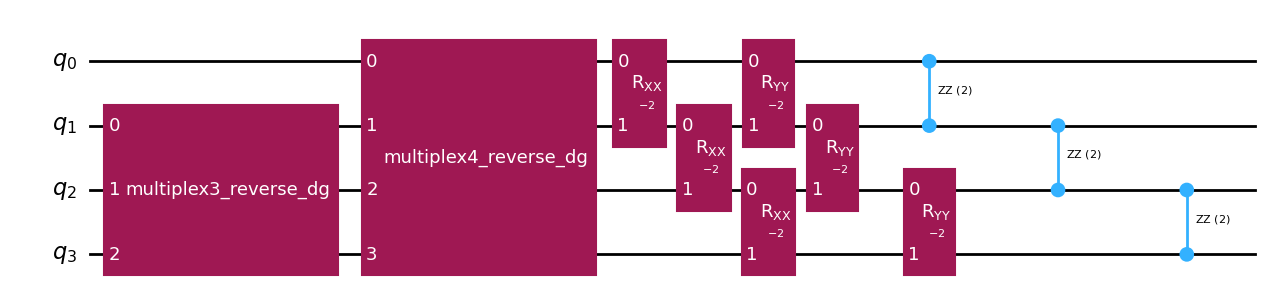

In [15]:
result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose("multiplex1_reverse_dg").draw("mpl")

In [10]:
magnetization_result_list = []
for i in range(num_qubits):
    magnetization_result_list.append(observables[:,i])

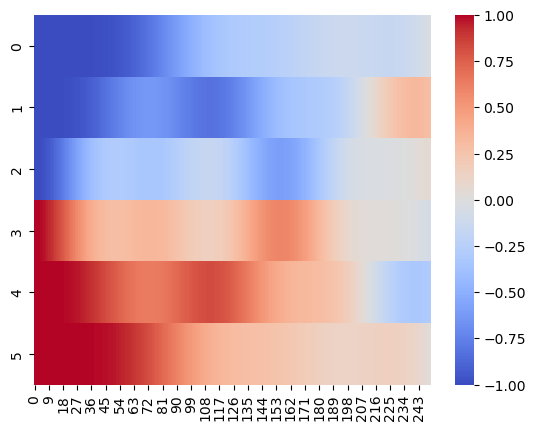

In [11]:
import seaborn as sns
local_mag = np.array(magnetization_result_list)
local_mag = local_mag.astype(float)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
plt.show()

In [13]:
import pandas as pd
df = pd.DataFrame({
    'Z4':local_mag[3],
    'Z6':local_mag[5]
})
df.to_csv('data\qiskit_local_mag.csv', index=False)

In [14]:
H = get_Hamiltonian(num_qubits,J,U,hj_list)
qc = get_wall_state(num_qubits)
problem = TimeEvolutionProblem(H, initial_state=qc, time=10., aux_operators=magnetization_op_list)
trotter = TrotterQRTE(num_timesteps=100, estimator=Estimator())
result = trotter.evolve(problem)
observables = np.array(np.array(result.observables)[:, :, 0])
magnetization_result_list = []
for i in range(num_qubits):
    magnetization_result_list.append(observables[:,i])
local_mag = np.array(magnetization_result_list)
local_mag = local_mag.astype(float)

df = pd.DataFrame({
    'Z6':local_mag[5]
})
df.to_csv('data\qiskit_local_mag_long.csv', index=False)

In [9]:
nhalf_result_dict = {}
fq_op_result_dict = {}
for h in [0,0.5,1.0,1.5,2.0]:
    hj_list = get_hjlist(num_qubits,h)

    H = get_Hamiltonian(num_qubits,J,U,hj_list)
    qc = get_wall_state(num_qubits)
    problem = TimeEvolutionProblem(H, initial_state=qc, time=t, aux_operators=[nhalf_op,fq_op1,fq_op2])
    trotter = TrotterQRTE(num_timesteps=n, estimator=Estimator())
    result = trotter.evolve(problem)
    observables = np.array(np.array(result.observables)[:, :, 0])

    nhalf_result = np.array(observables[:,0], dtype = float).flatten()
    fq_op1_result = np.array(observables[:,1],dtype = float).flatten()
    fq_op2_result = np.array(observables[:,2],dtype = float).flatten()
    fq_op_result = np.zeros(n, dtype = float)
    for i in range(n):
        fq_op_result[i] = fq_op1_result[i]/N - fq_op2_result[i]**2/N
    nhalf_result_dict[h] = nhalf_result
    fq_op_result_dict[h] = fq_op_result

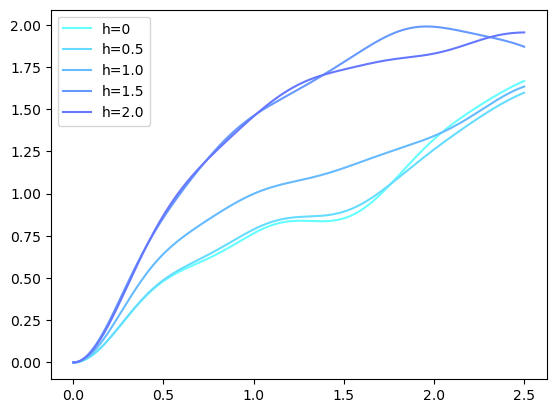

In [10]:
ticks = [dt*i for i in range(n+1)]
i = 0
color_list = ['#66ffff','#66ddff','#66bbff','#6699ff','#6677ff']
for h in [0,0.5,1.0,1.5,2.0]:
    plt.plot(ticks, nhalf_result_dict[h],color = color_list[i], label = f'h={h}')
    i+=1
plt.legend()
plt.show()

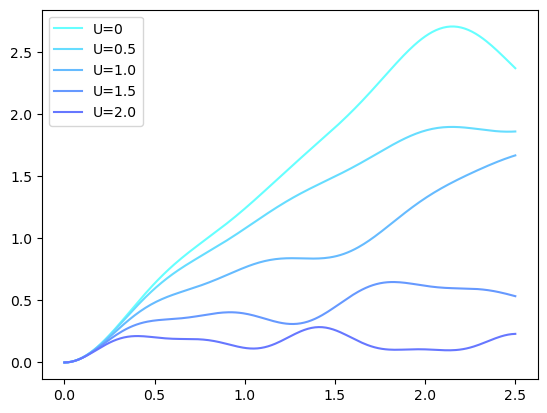

In [11]:
nhalf_result_dict = {}
fq_op_result_dict = {}
hj_list = [0]*num_qubits
for U in [0,0.5,1.0,1.5,2.0]:
    H = get_Hamiltonian(num_qubits,J,U,hj_list)
    qc = get_wall_state(num_qubits)
    problem = TimeEvolutionProblem(H, initial_state=qc, time=t, aux_operators=[nhalf_op,fq_op1,fq_op2])
    trotter = TrotterQRTE(num_timesteps=n, estimator=Estimator())
    result = trotter.evolve(problem)
    observables = np.array(np.array(result.observables)[:, :, 0])

    nhalf_result = np.array(observables[:,0], dtype = float).flatten()
    fq_op1_result = np.array(observables[:,1],dtype = float).flatten()
    fq_op2_result = np.array(observables[:,2],dtype = float).flatten()
    fq_op_result = np.zeros(n, dtype = float)
    for i in range(n):
        fq_op_result[i] = fq_op1_result[i]/N - fq_op2_result[i]**2/N
    nhalf_result_dict[U] = nhalf_result
    fq_op_result_dict[U] = fq_op_result

i=0
for U in [0,0.5,1.0,1.5,2.0]:
    plt.plot(ticks, nhalf_result_dict[U],color = color_list[i], label = f'U={U}')
    i+=1
plt.legend()
plt.show()

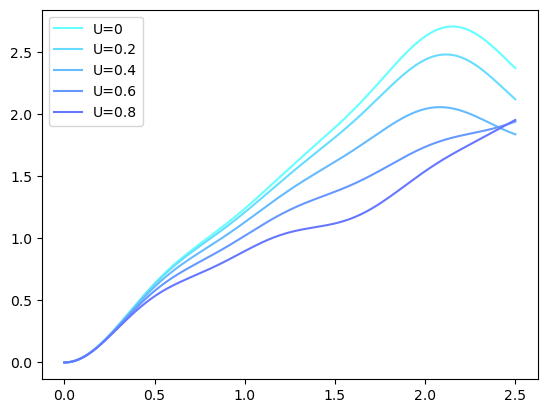

In [17]:
nhalf_result_dict = {}
fq_op_result_dict = {}
hj_list = [0]*num_qubits
ticks = [dt*i for i in range(n+1)]
color_list = ['#66ffff','#66ddff','#66bbff','#6699ff','#6677ff']
for U in [0,0.2,0.4,0.6,0.8]:
    H = get_Hamiltonian(num_qubits,J,U,hj_list)
    qc = get_wall_state(num_qubits)
    problem = TimeEvolutionProblem(H, initial_state=qc, time=t, aux_operators=[nhalf_op,fq_op1,fq_op2])
    trotter = TrotterQRTE(num_timesteps=n, estimator=Estimator())
    result = trotter.evolve(problem)
    observables = np.array(np.array(result.observables)[:, :, 0])

    nhalf_result = np.array(observables[:,0], dtype = float).flatten()
    fq_op1_result = np.array(observables[:,1],dtype = float).flatten()
    fq_op2_result = np.array(observables[:,2],dtype = float).flatten()
    fq_op_result = np.zeros(n, dtype = float)
    for i in range(n):
        fq_op_result[i] = fq_op1_result[i]/N - fq_op2_result[i]**2/N
    nhalf_result_dict[U] = nhalf_result
    fq_op_result_dict[U] = fq_op_result

i=0
for U in [0,0.2,0.4,0.6,0.8]:
    plt.plot(ticks, nhalf_result_dict[U],color = color_list[i], label = f'U={U}')
    i+=1
plt.legend()
plt.show()

In [22]:
temp_dict = {}
for i in range(2):
    H = get_Hamiltonian(num_qubits,J,U,hj_list)
    if i==0:
        qc = get_wall_state(num_qubits)
    else:
        qc = get_neel_state(num_qubits)
    problem = TimeEvolutionProblem(H, initial_state=qc, time=t, aux_operators=[fq_op1,fq_op2])
    trotter = TrotterQRTE(num_timesteps=n, estimator=Estimator())
    result = trotter.evolve(problem)
    observables = np.array(np.array(result.observables)[:, :, 0])
    fq_op1_result = np.array(observables[:,0],dtype = float).flatten()
    fq_op2_result = np.array(observables[:,1],dtype = float).flatten()
    fq_op_result = np.zeros(n, dtype = float)
    for j in range(n):
        fq_op_result[j] = fq_op1_result[j]/N - fq_op2_result[j]**2/N
    if i==0:
        temp_dict['wall_state']=fq_op_result
    else:
        temp_dict['neel_state']=fq_op_result
temp_df = pd.DataFrame(temp_dict)
temp_df.to_csv('data\qiskit_fn.csv', index=False)